In [1]:
import pandas as pd
import numpy as np
uci=pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\X_train.txt", delim_whitespace=True)
uci.to_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\X_train.csv", index=False)
df=pd.DataFrame(uci)
print(df.shape)

C:\Users\MSI\AppData\Local\Temp\ipykernel_3032\2556980845.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  uci=pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\X_train.txt", delim_whitespace=True)


(7351, 561)


In [2]:
import numpy as np

def load_signals(signal_folder):
    signal_names = [
        'total_acc_x', 'total_acc_y', 'total_acc_z',
        'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
        'body_acc_x', 'body_acc_y', 'body_acc_z',
    ]
    
    signals = []
    for name in signal_names:
        filepath = f"{signal_folder}/{name}_train.txt"
        data = np.loadtxt(filepath)
        signals.append(data)
    
    # Shape: (samples, time_steps, features)
    return np.stack(signals, axis=-1)

# Path to 'Inertial Signals'
signal_folder = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\Inertial Signals"

X_train = load_signals(signal_folder)
y_train = np.loadtxt(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt").astype(int)

print("X_train shape:", X_train.shape)  # (7352, 128, 9)
print("y_train shape:", y_train.shape)  # (7352,)


X_train shape: (7352, 128, 9)
y_train shape: (7352,)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load y_train
y_train_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt"
y_train = np.loadtxt(y_train_path).astype(int)


Class 1    1226
Class 2    1073
Class 3     986
Class 4    1286
Class 5    1374
Class 6    1407
Name: count, dtype: int64


C:\Users\MSI\AppData\Local\Temp\ipykernel_3032\2702579249.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


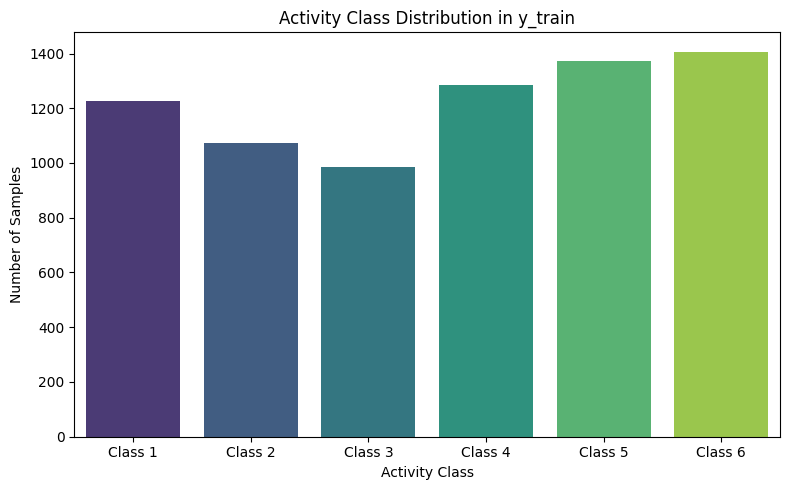

In [4]:
import pandas as pd

# Count each activity
class_counts = pd.Series(y_train).value_counts().sort_index()
class_counts.index = [f"Class {i}" for i in class_counts.index]
print(class_counts)
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Activity Class Distribution in y_train")
plt.ylabel("Number of Samples")
plt.xlabel("Activity Class")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Add, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import tensorflow as tf

# --- Load all sensor data and stack into 3D array (samples, timesteps, features) ---

def load_sensor_data(base_path, sensor_name):
    # sensor_name e.g. 'body_acc_x_train.txt'
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_train.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_train.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_train.txt')

body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_train.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_train.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_train.txt')

total_acc_x = load_sensor_data(base_path, 'total_acc_x_train.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_train.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_train.txt')

# Stack all 9 axes into (samples, timesteps, features=9)
# Each input file shape: (7352, 128) -- 7352 samples, 128 time steps each
X = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z
], axis=2)  # shape: (7352, 128, 9)

print("X shape:", X.shape)

# Load labels
y = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt", delim_whitespace=True, header=None).values.flatten()

# --- Standardize data per feature (flatten first) ---
nsamples, ntimesteps, nfeatures = X.shape
X_reshaped = X.reshape(-1, nfeatures)  # shape (7352*128, 9)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

X_scaled = X_scaled.reshape(nsamples, ntimesteps, nfeatures)

# Encode labels to 0-based integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Labels:", np.unique(y_encoded))




C:\Users\MSI\AppData\Local\Temp\ipykernel_3032\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_3032\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_3032\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_3032\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and

X shape: (7352, 128, 9)
Labels: [0 1 2 3 4 5]


C:\Users\MSI\AppData\Local\Temp\ipykernel_3032\669504868.py:45: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt", delim_whitespace=True, header=None).values.flatten()


In [10]:
# --- Prepare model building function (your code) ---

def build_cnn_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    conv1 = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    conv1 = BatchNormalization()(conv1)
    x = Add()([x, conv1])
    x = Dropout(0.2)(x)
    x = Conv1D(128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Stratified K-Fold training ---

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
f1_scores = []

# Since classes are unbalanced, compute class weights for full dataset (optional)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

for train_idx, val_idx in skf.split(X_scaled, y_encoded):
    print(f"\n📚 Training Fold {fold}")
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
    
    model = build_cnn_lstm_model(input_shape=(ntimesteps, nfeatures), num_classes=len(np.unique(y_encoded)))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        class_weight=class_weight_dict,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print(f"\n🧾 Fold {fold} Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_.astype(str)))
    
    report = classification_report(y_val, y_pred_classes, output_dict=True)
    f1_scores.append(report['macro avg']['f1-score'])
    
    fold += 1

print(f"\n✅ Average Macro F1-Score across {skf.n_splits} folds: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")


📚 Training Fold 1
Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.6720 - loss: 4.6567 - val_accuracy: 0.8124 - val_loss: 2.2272 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.8938 - loss: 1.6222 - val_accuracy: 0.7675 - val_loss: 1.4849 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9273 - loss: 1.0315 - val_accuracy: 0.8872 - val_loss: 0.8718 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9318 - loss: 0.7443 - val_accuracy: 0.9334 - val_loss: 0.6197 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.9223 - loss: 0.6779 - val_accuracy: 0.9014 - val_loss: 0.6087 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.9318 - loss: 0.5468 - val_accuracy: 0.9415 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - a

In [11]:
model.save(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\cnn_lstm_(UCI).h5")

C:\Users\MSI\AppData\Local\Temp\ipykernel_7692\1351853351.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_7692\1351853351.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_7692\1351853351.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_7692\1351853351.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated

X_test shape: (2947, 128, 9)


C:\Users\MSI\AppData\Local\Temp\ipykernel_7692\1351853351.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_test = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\y_test.txt", delim_whitespace=True, header=None).values.flatten()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
Accuracy: 0.9300984051577876

Classification Report:

              precision    recall  f1-score   support

           1       1.00      0.99      0.99       496
           2       0.96      0.96      0.96       471
           3       0.95      0.97      0.96       420
           4       0.79      0.90      0.84       491
           5       0.91      0.77      0.84       532
           6       0.99      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



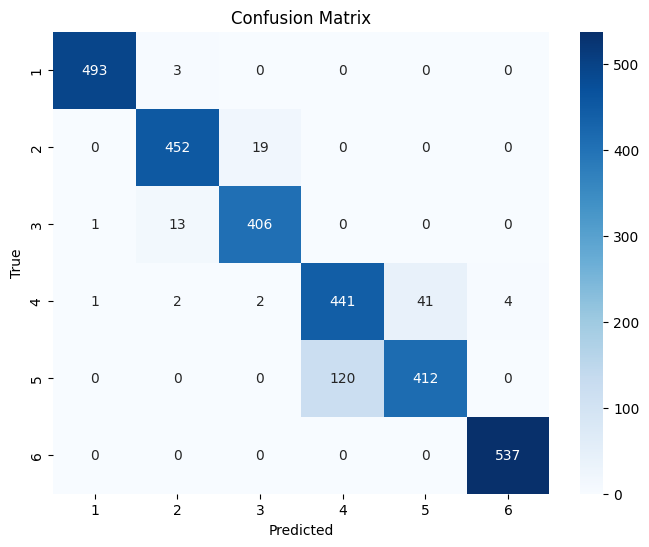

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load test sensor signal data from UCI HAR Dataset ---
def load_sensor_data(base_path, sensor_name):
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

# Use the TEST path, not TRAIN
base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_test.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_test.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_test.txt')

body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_test.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_test.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_test.txt')

total_acc_x = load_sensor_data(base_path, 'total_acc_x_test.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_test.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_test.txt')

# Stack all 9 axes into shape: (samples, timesteps, features=9)
X_test = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z
], axis=2)

print("X_test shape:", X_test.shape)  # should be (2947, 128, 9)

# --- Load test labels ---
y_test = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\y_test.txt", delim_whitespace=True, header=None).values.flatten()

# --- Standardize data ---
nsamples, ntimesteps, nfeatures = X_test.shape
X_test_reshaped = X_test.reshape(-1, nfeatures)  # shape: (2947*128, 9)

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_reshaped)

X_test_scaled = X_test_scaled.reshape(nsamples, ntimesteps, nfeatures)

# --- Label encode y_test ---
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# --- Load your trained model ---
model = load_model(r'C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\Models\Best_Model({fold}).h5')

# --- Predict ---
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- Evaluate ---
# === Evaluate ===
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_classes))
print("\nClassification Report:\n")
# Convert class labels to string if they are integers
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test_encoded, y_pred_classes, target_names=target_names))

# --- Confusion matrix ---
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.summary()

C:\Users\MSI\AppData\Local\Temp\ipykernel_23432\3164788274.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_23432\3164788274.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_23432\3164788274.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_23432\3164788274.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprec

Original X_test shape: (2947, 128, 9)
Reduced X_test shape: (1473, 128, 9)


C:\Users\MSI\AppData\Local\Temp\ipykernel_23432\3164788274.py:41: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_test = pd.read_csv(


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Accuracy: 0.9287169042769857

Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       241
           2       1.00      0.96      0.98       246
           3       0.96      0.99      0.98       197
           4       0.79      0.85      0.82       256
           5       0.85      0.78      0.81       254
           6       0.99      1.00      0.99       279

    accuracy                           0.93      1473
   macro avg       0.93      0.93      0.93      1473
weighted avg       0.93      0.93      0.93      1473



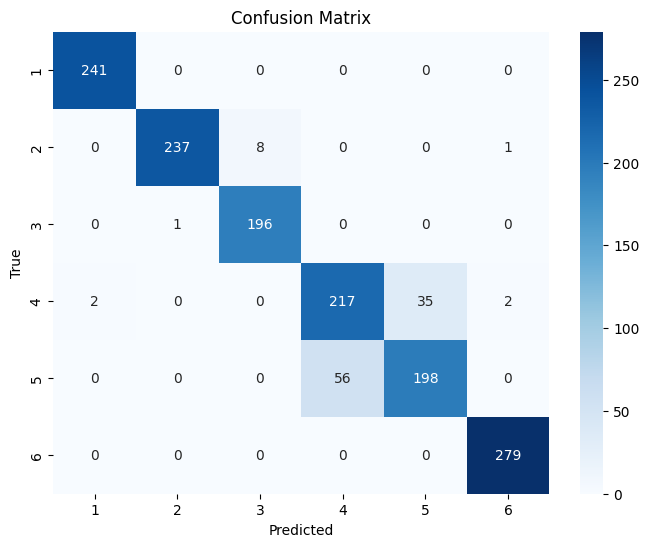

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns


# --- Load test sensor signal data from UCI HAR Dataset ---
def load_sensor_data(base_path, sensor_name):
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

# Use the TEST path
base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_test.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_test.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_test.txt')

body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_test.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_test.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_test.txt')

total_acc_x = load_sensor_data(base_path, 'total_acc_x_test.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_test.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_test.txt')

# Stack all 9 axes into shape: (samples, timesteps, features=9)
X_test = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z
], axis=2)

print("Original X_test shape:", X_test.shape)  # (2947, 128, 9)

# --- Load test labels ---
y_test = pd.read_csv(
    r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\y_test.txt",
    delim_whitespace=True,
    header=None
).values.flatten()

# --- Reduce test data by 50% ---
np.random.seed(42)  # for reproducibility
indices = np.random.choice(X_test.shape[0], size=X_test.shape[0] // 2, replace=False)
X_test = X_test[indices]
y_test = y_test[indices]

print("Reduced X_test shape:", X_test.shape)  # ~1473 samples

# --- Standardize data ---
nsamples, ntimesteps, nfeatures = X_test.shape
X_test_reshaped = X_test.reshape(-1, nfeatures)  # shape: (samples*timesteps, 9)

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(nsamples, ntimesteps, nfeatures)

# --- Label encode y_test ---
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# --- Load your trained model ---
model = load_model(r'C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\Models\cnn_lstm_(UCI).h5')


# --- Predict ---
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- Evaluate ---
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_classes))
print("\nClassification Report:\n")
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test_encoded, y_pred_classes, target_names=target_names))

# --- Confusion matrix ---
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\2217169469.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\2217169469.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\2217169469.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\2217169469.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated

X_test shape: (2947, 128, 9)
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Accuracy: 0.9345096708517137

Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       496
           2       0.99      0.97      0.98       471
           3       0.97      1.00      0.98       420
           4       0.79      0.88      0.83       491
           5       0.90      0.78      0.84       532
           6       0.99      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.93      0.93      2947



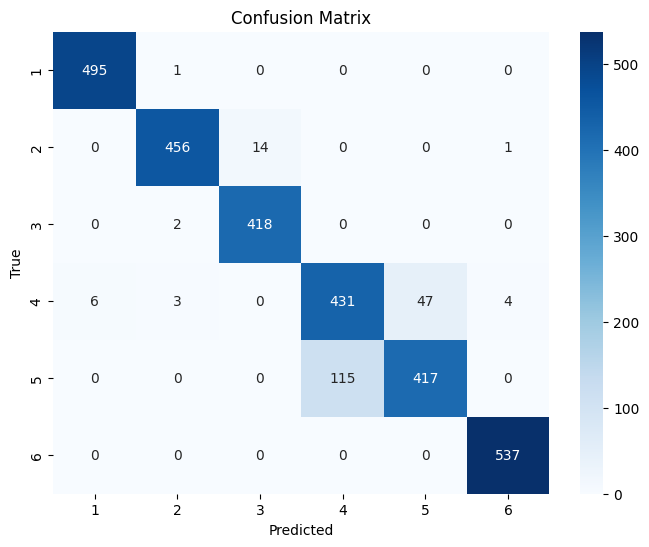

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load test sensor signal data from UCI HAR Dataset ---
def load_sensor_data(base_path, sensor_name):
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

# Use the TEST path, not TRAIN
base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_test.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_test.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_test.txt')

body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_test.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_test.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_test.txt')

total_acc_x = load_sensor_data(base_path, 'total_acc_x_test.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_test.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_test.txt')

# Stack all 9 axes into shape: (samples, timesteps, features=9)
X_test = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z
], axis=2)

print("X_test shape:", X_test.shape)  # should be (2947, 128, 9)

# --- Load test labels ---
y_test = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\y_test.txt", delim_whitespace=True, header=None).values.flatten()

# --- Standardize data ---
nsamples, ntimesteps, nfeatures = X_test.shape
X_test_reshaped = X_test.reshape(-1, nfeatures)  # shape: (2947*128, 9)

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_reshaped)

X_test_scaled = X_test_scaled.reshape(nsamples, ntimesteps, nfeatures)

# --- Label encode y_test ---
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# --- Load your trained model ---
model = load_model(r'C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\cnn_lstm_(UCI).h5')

# --- Predict ---
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- Evaluate ---
# === Evaluate ===
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_classes))
print("\nClassification Report:\n")
# Convert class labels to string if they are integers
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test_encoded, y_pred_classes, target_names=target_names))

# --- Confusion matrix ---
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Add, LSTM, Dense, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.fft import rfft
import os

# --- Load Sensor Data ---
def load_sensor_data(base_path, sensor_name):
    return pd.read_csv(os.path.join(base_path, sensor_name), delim_whitespace=True, header=None).values

base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\Inertial Signals"

sensor_axes = ['body_acc_x', 'body_acc_y', 'body_acc_z',
               'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
               'total_acc_x', 'total_acc_y', 'total_acc_z']

sensor_data = {name: load_sensor_data(base_path, f"{name}_train.txt") for name in sensor_axes}

# --- Compute Pitch and Roll ---
def compute_pitch_roll(acc_x, acc_y, acc_z):
    pitch = np.arctan2(acc_x, np.sqrt(acc_y**2 + acc_z**2))
    roll = np.arctan2(acc_y, np.sqrt(acc_x**2 + acc_z**2))
    return pitch, roll

pitch, roll = compute_pitch_roll(sensor_data['total_acc_x'], sensor_data['total_acc_y'], sensor_data['total_acc_z'])

# --- Stack all dynamic features ---
X = np.stack([*sensor_data.values(), pitch, roll], axis=-1)  # shape: (samples, timesteps, features)
n_samples, n_timesteps, n_features = X.shape

# --- Static Features ---
def extract_static_features(X):
    sma = np.mean(np.abs(X), axis=1)
    var = np.var(X, axis=1)
    dom_freq = np.zeros((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            yf = rfft(X[i, :, j])
            dom_freq[i, j] = np.argmax(np.abs(yf))
    return np.concatenate([sma, var, dom_freq], axis=1)

X_static = extract_static_features(X)  # shape: (samples, features * 3)

# --- Standardize ---
scaler_dyn = StandardScaler()
X_scaled = scaler_dyn.fit_transform(X.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)

scaler_static = StandardScaler()
X_static_scaled = scaler_static.fit_transform(X_static)

# --- Load and Encode Labels ---
y_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt"
y = pd.read_csv(y_path, header=None).values.flatten()
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))



C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\3237524423.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(os.path.join(base_path, sensor_name), delim_whitespace=True, header=None).values
C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\3237524423.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(os.path.join(base_path, sensor_name), delim_whitespace=True, header=None).values
C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\3237524423.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(os.path.join(base_path, sensor_name), delim_whitespace=True, header=None).values
C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\3237524423.py:16: FutureWa

In [7]:
# --- Build Model ---
def build_model(dynamic_shape, static_shape, num_classes):
    dyn_input = Input(shape=dynamic_shape)
    x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(dyn_input)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    residual = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    residual = BatchNormalization()(residual)
    x = Add()([x, residual])
    x = Dropout(0.3)(x)
    x = Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = LSTM(128, return_sequences=False)(x)
    x = Dropout(0.3)(x)

    static_input = Input(shape=(static_shape,))
    combined = Concatenate()([x, static_input])
    x = Dense(128, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[dyn_input, static_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Train with K-Fold ---
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y_encoded), 1):
    print(f"\n📘 Fold {fold}")
    X_train_dyn, X_val_dyn = X_scaled[train_idx], X_scaled[val_idx]
    X_train_static, X_val_static = X_static_scaled[train_idx], X_static_scaled[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    model = build_model(dynamic_shape=(n_timesteps, n_features), static_shape=X_static_scaled.shape[1], num_classes=num_classes)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
    ]

    model.fit(
        [X_train_dyn, X_train_static], y_train,
        validation_data=([X_val_dyn, X_val_static], y_val),
        epochs=50,
        batch_size=64,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )

    y_pred = model.predict([X_val_dyn, X_val_static])
    y_pred_labels = np.argmax(y_pred, axis=1)

    print("\n📊 Classification Report:")
    print(classification_report(y_val, y_pred_labels, target_names=label_encoder.classes_.astype(str)))



📘 Fold 1
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.5959 - loss: 2.4986 - val_accuracy: 0.8172 - val_loss: 1.3670 - learning_rate: 0.0010
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.8796 - loss: 1.1654 - val_accuracy: 0.9211 - val_loss: 0.8003 - learning_rate: 0.0010
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.9259 - loss: 0.7122 - val_accuracy: 0.8517 - val_loss: 0.7531 - learning_rate: 0.0010
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step - accuracy: 0.9285 - loss: 0.5597 - val_accuracy: 0.9121 - val_loss: 0.5378 - learning_rate: 0.0010
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.9298 - loss: 0.4822 - val_accuracy: 0.9497 - val_loss: 0.3807 - learning_rate: 0.0010
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - accuracy: 0.9341 - loss: 0.3725 - val_accuracy: 0.9437 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 240ms/step - accuracy: 0.9351 

In [8]:
model.save(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\cnn_lstm_(3).h5")

C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\881505058.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\881505058.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\881505058.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_8924\881505058.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
Accuracy: 0.9287410926365796

Classification Report:

              precision    recall  f1-score   support

           1       0.97      0.97      0.97       496
           2       1.00      0.95      0.97       471
           3       0.95      1.00      0.97       420
           4       0.79      0.87      0.83       491
           5       0.88      0.79      0.83       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



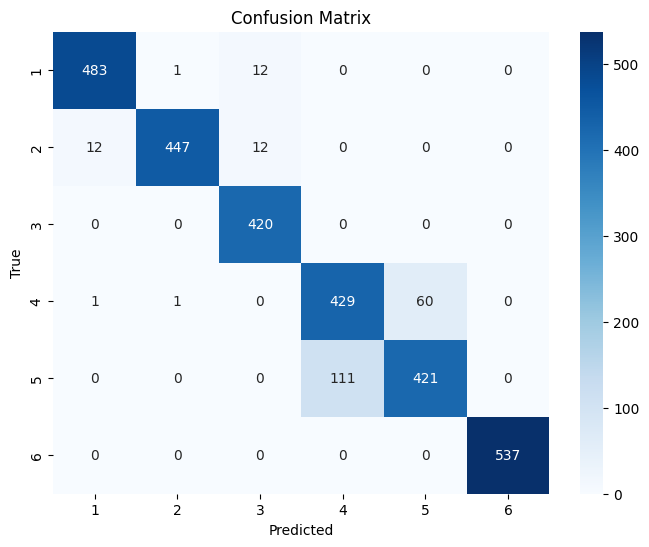

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from scipy.fft import rfft
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load test sensor signal data from UCI HAR Dataset ---
def load_sensor_data(base_path, sensor_name):
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\Inertial Signals\\"

# Load all 9 sensor axes
sensor_axes = ['body_acc_x', 'body_acc_y', 'body_acc_z',
               'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
               'total_acc_x', 'total_acc_y', 'total_acc_z']

sensor_data = {name: load_sensor_data(base_path, f"{name}_test.txt") for name in sensor_axes}

# --- Compute pitch and roll orientation features ---
def compute_pitch_roll(acc_x, acc_y, acc_z):
    pitch = np.arctan2(acc_x, np.sqrt(acc_y**2 + acc_z**2))
    roll = np.arctan2(acc_y, np.sqrt(acc_x**2 + acc_z**2))
    return pitch, roll

pitch, roll = compute_pitch_roll(sensor_data['total_acc_x'], sensor_data['total_acc_y'], sensor_data['total_acc_z'])

# --- Stack original 9 features + pitch and roll => total 11 features ---
X_dyn_test = np.stack([*sensor_data.values(), pitch, roll], axis=-1)  # shape: (samples, timesteps, features)

# --- Extract static features (SMA, Variance, Dominant Frequency) ---
def extract_static_features(X):
    sma = np.mean(np.abs(X), axis=1)
    var = np.var(X, axis=1)
    dom_freq = np.zeros((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            yf = rfft(X[i, :, j])
            dom_freq[i, j] = np.argmax(np.abs(yf))
    return np.concatenate([sma, var, dom_freq], axis=1)

X_static_test = extract_static_features(X_dyn_test)  # shape: (samples, features * 3)

# --- Standardize dynamic and static features ---
n_samples, n_timesteps, n_features = X_dyn_test.shape

# Standardize dynamic features
scaler_dyn = StandardScaler()
X_dyn_test_scaled = scaler_dyn.fit_transform(X_dyn_test.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)

# Standardize static features
scaler_static = StandardScaler()
X_static_test_scaled = scaler_static.fit_transform(X_static_test)

# --- Load test labels ---
y_test = pd.read_csv(
    r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\y_test.txt",
    delim_whitespace=True, header=None).values.flatten()

# --- Label encode y_test ---
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# --- Load trained model ---
model = load_model(r'C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\cnn_lstm_(3).h5')

# --- Predict ---
y_pred_probs = model.predict([X_dyn_test_scaled, X_static_test_scaled])
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- Evaluation ---
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_classes))
print("\nClassification Report:\n")
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test_encoded, y_pred_classes, target_names=target_names))

# --- Confusion matrix ---
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
